
End-to-end training with cleaning, augmentation, MLflow logging, evaluation

In [1]:
%pip install --upgrade pip
%pip install tensorflow==2.15.0
%pip install mlflow==2.15.1
%pip install -y mlflow-skinny
%pip install pillow
%pip install numpy 
%pip install protobuf==4.25.3

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

[optparse.groups]Usage:[/]   
  /Users/Durgesh/Documents/BitsLearning/Semester3/Assignment1/venv/bin/python -m pip install \[options] <requirement specifier> \[package-index-options] ...
  /Users/Durgesh/Documents/BitsLearning/Semester3/Assignment1/venv/bin/python -m pip install \[options] -r <requirements file> \[package-index-options] ...
  /Users/Durgesh/Documents/BitsLearning/Semester3/Assignment1/venv/bin/python -m pip install \[options] [-e] <vcs project url> ...
  /Users/Durgesh/Documents/BitsLearning/Semester3/Assignment1/venv/bin/python -m pip install \[options] [-e] <local project path> ...
  /Users/Durgesh/Documents/BitsLearning/Semester3/Assignment1/venv/bin/python -m pip install \[options] <archive url/path> ...

no such option: -y
Note: you may need to restart the kernel to us

In [2]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import mlflow
import mlflow.tensorflow

DATA_DIR = '/Users/Durgesh/Documents/BitsLearning/Semester3/MLOPS/Assignment2/cats_dogs_mlops/PetImages'
IMG_SIZE = (224,224)
BATCH_SIZE = 32
EPOCHS = 5

mlflow.set_experiment('cats_dogs_final')
print('Setup complete')


2026-02-21 15:09:53.873925: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026/02/21 15:09:59 INFO mlflow.tracking.fluent: Experiment with name 'cats_dogs_final' does not exist. Creating a new experiment.


Setup complete


In [3]:
# Remove corrupted images
def remove_corrupt_images(folder):
    removed=0
    for root,_,files in os.walk(folder):
        for f in files:
            path=os.path.join(root,f)
            try:
                img=Image.open(path)
                img.verify()
            except:
                os.remove(path)
                removed+=1
    print('Removed',removed,'corrupted images')

remove_corrupt_images(DATA_DIR)


/Users/Durgesh/Documents/BitsLearning/Semester3/Assignment1/venv/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Removed 0 corrupted images


In [4]:
# Load dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

train_ds = train_ds.apply(tf.data.experimental.ignore_errors())
val_ds   = val_ds.apply(tf.data.experimental.ignore_errors())

AUTOTUNE=tf.data.AUTOTUNE
train_ds=train_ds.prefetch(AUTOTUNE)
val_ds=val_ds.prefetch(AUTOTUNE)

print('Dataset loaded')


Found 24998 files belonging to 2 classes.
Using 19999 files for training.
Found 24998 files belonging to 2 classes.
Using 4999 files for validation.
Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.
Dataset loaded


In [5]:
# Data augmentation
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


In [6]:
# Build model
model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224,224,3)),
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),

    tf.keras.layers.Conv2D(16,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                 

In [7]:
# Train with MLflow
with mlflow.start_run():
    history=model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS)

    model.save('model.h5')
    mlflow.log_artifact('model.h5')
    mlflow.log_metric('final_accuracy',history.history['accuracy'][-1])

print('Training complete, model saved.')


Epoch 1/5
    147/Unknown - 76s 505ms/step - loss: 0.7564 - accuracy: 0.5704

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


    250/Unknown - 128s 504ms/step - loss: 0.7088 - accuracy: 0.5968

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


    256/Unknown - 131s 504ms/step - loss: 0.7067 - accuracy: 0.5972

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


    295/Unknown - 150s 504ms/step - loss: 0.6922 - accuracy: 0.6084

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


    309/Unknown - 157s 504ms/step - loss: 0.6883 - accuracy: 0.6120

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


    349/Unknown - 177s 503ms/step - loss: 0.6796 - accuracy: 0.6188

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


    424/Unknown - 215s 503ms/step - loss: 0.6675 - accuracy: 0.6291

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


    430/Unknown - 218s 503ms/step - loss: 0.6662 - accuracy: 0.6302

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


    497/Unknown - 252s 504ms/step - loss: 0.6588 - accuracy: 0.6361

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


    577/Unknown - 293s 506ms/step - loss: 0.6499 - accuracy: 0.6429

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


    622/Unknown - 317s 507ms/step - loss: 0.6468 - accuracy: 0.6456

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


622/622 [==============================] - 338s 541ms/step - loss: 0.6468 - accuracy: 0.6456 - val_loss: 0.5844 - val_accuracy: 0.6913
Epoch 2/5
147/622 [======>.......................] - ETA: 4:51 - loss: 0.5899 - accuracy: 0.6805

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


250/622 [===========>..................] - ETA: 3:47 - loss: 0.5851 - accuracy: 0.6864

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


256/622 [===========>..................] - ETA: 3:43 - loss: 0.5824 - accuracy: 0.6890

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


295/622 [=============>................] - ETA: 3:15 - loss: 0.5785 - accuracy: 0.6938

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/622 [=============>................] - ETA: 3:05 - loss: 0.5785 - accuracy: 0.6945

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


349/622 [===============>..............] - ETA: 2:38 - loss: 0.5775 - accuracy: 0.6970

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


424/622 [===================>..........] - ETA: 1:52 - loss: 0.5738 - accuracy: 0.7000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


430/622 [===================>..........] - ETA: 1:49 - loss: 0.5727 - accuracy: 0.7008

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


497/622 [======================>.......] - ETA: 1:11 - loss: 0.5739 - accuracy: 0.6989

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


577/622 [==========================>...] - ETA: 26s - loss: 0.5700 - accuracy: 0.7025

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


622/622 [==============================] - ETA: 0s - loss: 0.5717 - accuracy: 0.7015

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


622/622 [==============================] - 390s 627ms/step - loss: 0.5717 - accuracy: 0.7015 - val_loss: 0.5600 - val_accuracy: 0.7139
Epoch 3/5
147/622 [======>.......................] - ETA: 5:05 - loss: 0.5663 - accuracy: 0.7153

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


250/622 [===========>..................] - ETA: 3:55 - loss: 0.5605 - accuracy: 0.7182

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


256/622 [===========>..................] - ETA: 3:52 - loss: 0.5604 - accuracy: 0.7172

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


295/622 [=============>................] - ETA: 3:27 - loss: 0.5571 - accuracy: 0.7202

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/622 [=============>................] - ETA: 3:18 - loss: 0.5541 - accuracy: 0.7226

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


349/622 [===============>..............] - ETA: 2:52 - loss: 0.5504 - accuracy: 0.7243

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


424/622 [===================>..........] - ETA: 2:02 - loss: 0.5458 - accuracy: 0.7254

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


430/622 [===================>..........] - ETA: 1:58 - loss: 0.5451 - accuracy: 0.7257

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


497/622 [======================>.......] - ETA: 1:17 - loss: 0.5456 - accuracy: 0.7255

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


577/622 [==========================>...] - ETA: 28s - loss: 0.5440 - accuracy: 0.7264

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


622/622 [==============================] - ETA: 0s - loss: 0.5445 - accuracy: 0.7264

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


622/622 [==============================] - 414s 666ms/step - loss: 0.5445 - accuracy: 0.7264 - val_loss: 0.5279 - val_accuracy: 0.7389
Epoch 4/5
147/622 [======>.......................] - ETA: 5:11 - loss: 0.5369 - accuracy: 0.7251

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


250/622 [===========>..................] - ETA: 3:58 - loss: 0.5281 - accuracy: 0.7333

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


256/622 [===========>..................] - ETA: 3:54 - loss: 0.5286 - accuracy: 0.7327

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


295/622 [=============>................] - ETA: 3:29 - loss: 0.5260 - accuracy: 0.7350

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/622 [=============>................] - ETA: 3:20 - loss: 0.5253 - accuracy: 0.7362

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


349/622 [===============>..............] - ETA: 2:54 - loss: 0.5221 - accuracy: 0.7393

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


424/622 [===================>..........] - ETA: 2:06 - loss: 0.5195 - accuracy: 0.7427

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


430/622 [===================>..........] - ETA: 2:02 - loss: 0.5190 - accuracy: 0.7430

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


497/622 [======================>.......] - ETA: 1:19 - loss: 0.5183 - accuracy: 0.7442

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


577/622 [==========================>...] - ETA: 28s - loss: 0.5155 - accuracy: 0.7462

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


622/622 [==============================] - ETA: 0s - loss: 0.5144 - accuracy: 0.7465

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


622/622 [==============================] - 422s 678ms/step - loss: 0.5144 - accuracy: 0.7465 - val_loss: 0.5120 - val_accuracy: 0.7524
Epoch 5/5
147/622 [======>.......................] - ETA: 4:43 - loss: 0.5111 - accuracy: 0.7472

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


250/622 [===========>..................] - ETA: 3:34 - loss: 0.5008 - accuracy: 0.7561

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


256/622 [===========>..................] - ETA: 3:31 - loss: 0.5003 - accuracy: 0.7571

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


295/622 [=============>................] - ETA: 3:10 - loss: 0.4958 - accuracy: 0.7597

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/622 [=============>................] - ETA: 3:03 - loss: 0.4950 - accuracy: 0.7593

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


349/622 [===============>..............] - ETA: 2:43 - loss: 0.4916 - accuracy: 0.7608

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


424/622 [===================>..........] - ETA: 1:56 - loss: 0.4917 - accuracy: 0.7599

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


430/622 [===================>..........] - ETA: 1:52 - loss: 0.4908 - accuracy: 0.7600

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


497/622 [======================>.......] - ETA: 1:11 - loss: 0.4920 - accuracy: 0.7602

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


577/622 [==========================>...] - ETA: 25s - loss: 0.4925 - accuracy: 0.7598

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


622/622 [==============================] - ETA: 0s - loss: 0.4916 - accuracy: 0.7603

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


622/622 [==============================] - 388s 624ms/step - loss: 0.4916 - accuracy: 0.7603 - val_loss: 0.4789 - val_accuracy: 0.7716


/Users/Durgesh/Documents/BitsLearning/Semester3/Assignment1/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training complete, model saved.


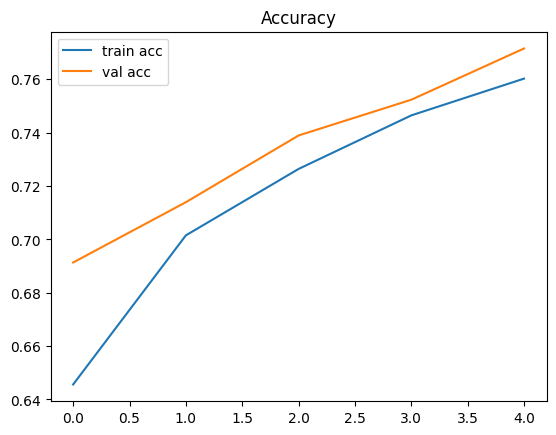

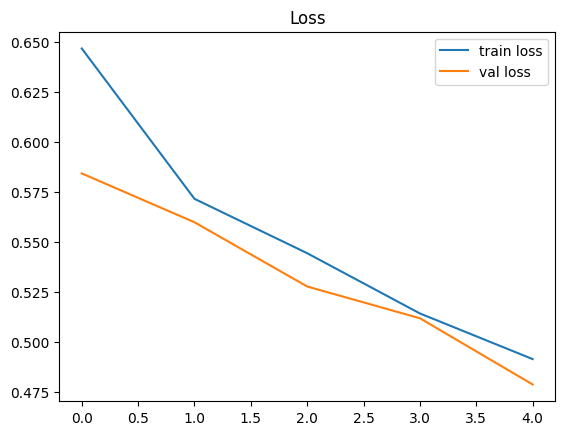

In [8]:
# Plot curves
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],label='train acc')
plt.plot(history.history['val_accuracy'],label='val acc')
plt.legend(); plt.title('Accuracy'); plt.show()

plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.legend(); plt.title('Loss'); plt.show()


1/1 [==============================] - 0s 120ms/step


/var/folders/kc/1kd7kwk9659g1_8mmf6s6n800000gp/T/ipykernel_7922/2086277204.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label=class_names[int(preds[i]>0.5)]


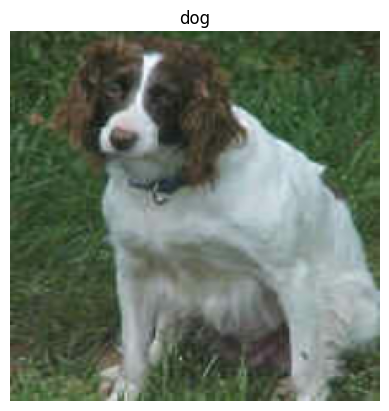

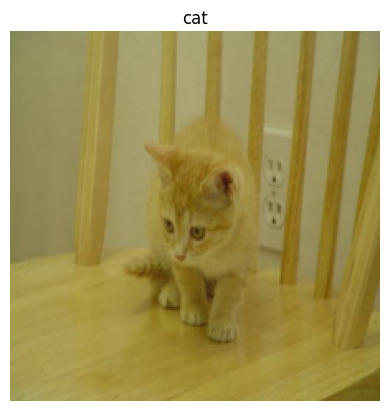

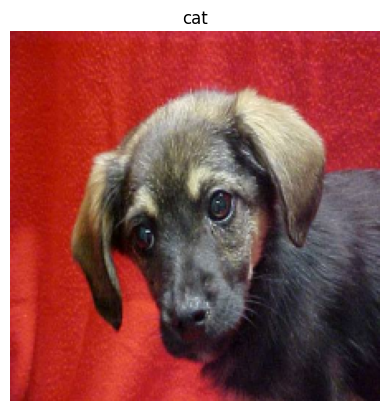

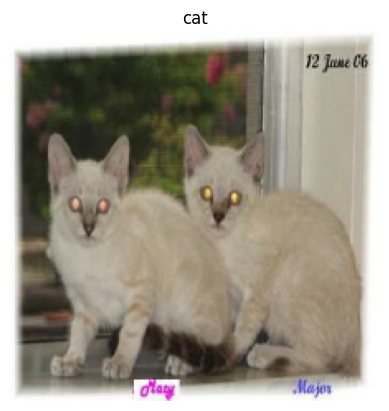

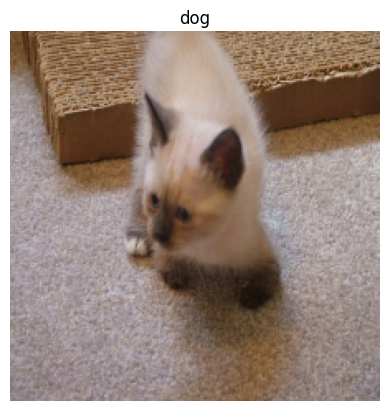

In [9]:
# Sample predictions
class_names=['cat','dog']
for images,labels in train_ds.take(1):
    preds=model.predict(images[:5])
    for i in range(5):
        plt.imshow(images[i].numpy().astype('uint8'))
        label=class_names[int(preds[i]>0.5)]
        plt.title(label)
        plt.axis('off')
        plt.show()
    break
